In [1]:
# из библиотеки google.colab импортируем класс files
from google.colab import files

# создаем объект этого класса, применяем метод .upload()
uploaded = files.upload()

Saving VisDrone2019-DET-val.zip to VisDrone2019-DET-val.zip


In [2]:
!unzip "/content/VisDrone2019-DET-val.zip" -d "/content/dataset"

Archive:  /content/VisDrone2019-DET-val.zip
   creating: /content/dataset/VisDrone2019-DET-val/
  inflating: /content/dataset/VisDrone2019-DET-val/.DS_Store  
   creating: /content/dataset/VisDrone2019-DET-val/annotations/
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_02999_d_0000005.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_03499_d_0000006.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_03999_d_0000007.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_04527_d_0000008.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05249_d_0000009.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05499_d_0000010.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05999_d_0000011.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_07999_d_0000012.txt  
  inflating: /content/dataset/Vis


Для изображения ниже выбран: шум Гаусса


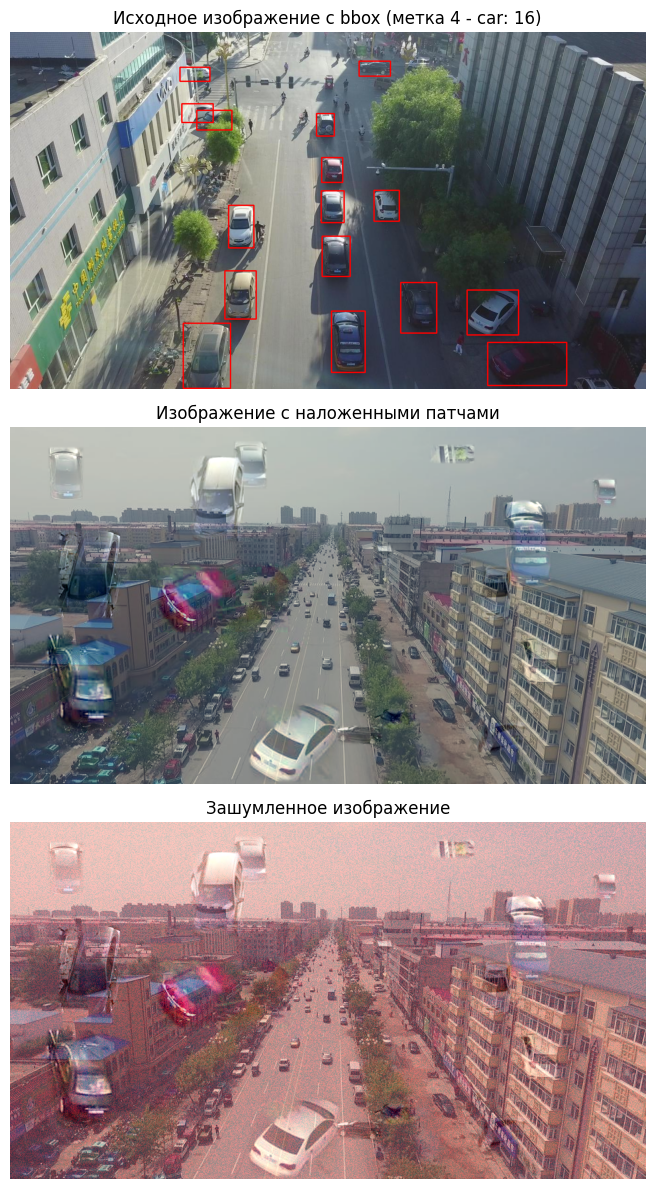


Метрики фильтров шумоподавления:
Фильтр: Median, MSE = 938.85, SSIM = 0.7199, Время работы = 0.0016 секунд
Фильтр: Gaussian, MSE = 864.09, SSIM = 0.7912, Время работы = 0.0020 секунд
Фильтр: Bilateral, MSE = 843.43, SSIM = 0.8086, Время работы = 0.0863 секунд
Фильтр: NLM, MSE = 791.91, SSIM = 0.7735, Время работы = 1.5335 секунд
Фильтр: Geometric, MSE = 780.66, SSIM = 0.7504, Время работы = 9.9888 секунд

Для изображения ниже выбран: постоянный шум


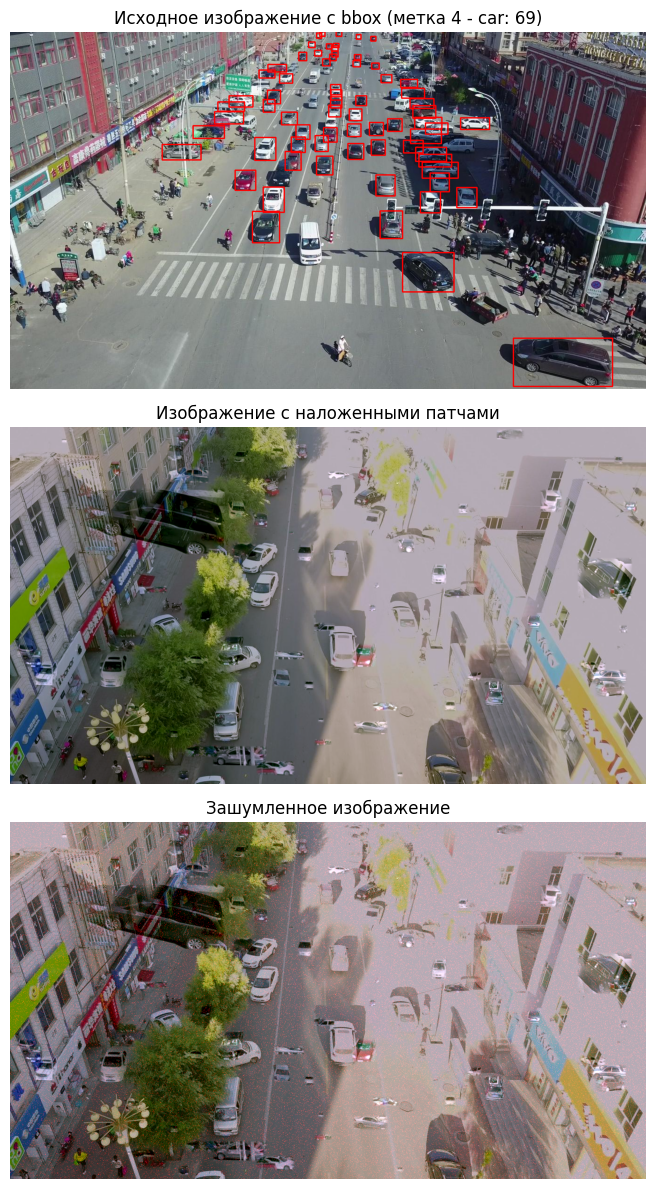


Метрики фильтров шумоподавления:
Фильтр: Median, MSE = 41.82, SSIM = 0.9162, Время работы = 0.0021 секунд
Фильтр: Gaussian, MSE = 103.22, SSIM = 0.8250, Время работы = 0.0014 секунд
Фильтр: Bilateral, MSE = 88.90, SSIM = 0.8333, Время работы = 0.1482 секунд
Фильтр: NLM, MSE = 84.51, SSIM = 0.8395, Время работы = 3.1371 секунд
Фильтр: Geometric, MSE = 88.25, SSIM = 0.8265, Время работы = 20.1113 секунд

Для изображения ниже выбран: шум Гаусса


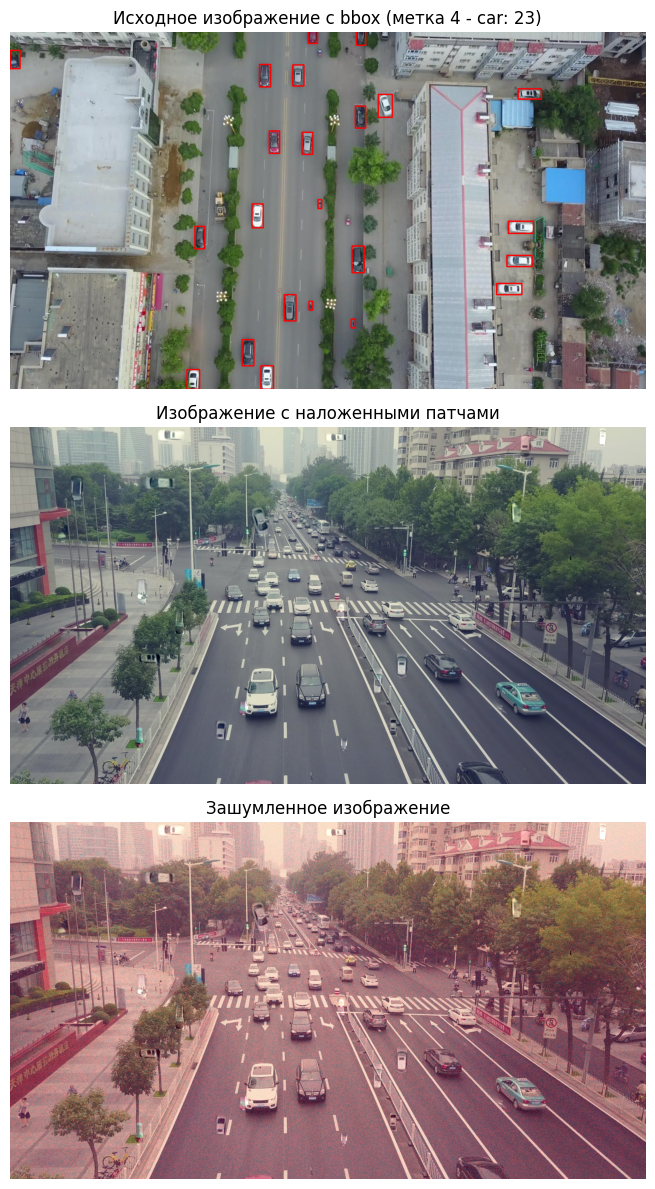


Метрики фильтров шумоподавления:
Фильтр: Median, MSE = 928.11, SSIM = 0.7419, Время работы = 0.0026 секунд
Фильтр: Gaussian, MSE = 867.07, SSIM = 0.8011, Время работы = 0.0014 секунд
Фильтр: Bilateral, MSE = 844.17, SSIM = 0.8065, Время работы = 0.1497 секунд
Фильтр: NLM, MSE = 779.50, SSIM = 0.7852, Время работы = 3.6946 секунд
Фильтр: Geometric, MSE = 774.54, SSIM = 0.7707, Время работы = 19.6144 секунд


In [16]:
from __future__ import annotations

import numpy as np
import cv2
import copy
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
from skimage.metrics import mean_squared_error, structural_similarity as ssim

class ChessBoardWildFashionDataset(Dataset):

    def __init__(
        self,
        dataset_size: int,
        visdrone_images_path: str,
        visdrone_annotations_path: str,
        mean: float = 0.0,
        std: float = 25.0,
        amplitude: float = 50.0,
        counter: int = 0
    ):
        self.dataset_size = dataset_size
        self.images_path = visdrone_images_path
        self.annotations_path = visdrone_annotations_path
        self.image_files = [f for f in os.listdir(self.images_path) if f.endswith(".jpg")]
        self.annotation_files = [f.replace(".jpg", ".txt") for f in self.image_files]
        self.mean = mean
        self.std = std
        self.amplitude = amplitude
        self.counter = 0

    def __len__(self):
        return self.dataset_size

    def load_image(self, filename):
        return cv2.cvtColor(cv2.imread(os.path.join(self.images_path, filename)), cv2.COLOR_BGR2RGB)

    def load_annotations(self, filename):
        bboxes = []
        with open(os.path.join(self.annotations_path, filename), 'r') as f:
            for line in f.readlines():
                values = list(map(int, line.strip().split(',')))
                x, y, w, h, _, category = values[:6]
                if category == 4:
                    bboxes.append((x, y, x + w, y + h))
        return bboxes

    def compute_color_statistics(self, image):
        mean, std = cv2.meanStdDev(image)
        return mean.flatten(), std.flatten()

    def apply_color_correction(self, src, ref):
        src_mean, src_std = self.compute_color_statistics(src) #http://www.graph.unn.ru/rus/materials/CG/CG03_ImageProcessing.pdf
        ref_mean, ref_std = self.compute_color_statistics(ref)
        adjusted = ((src - src_mean) * (ref_std / src_std)) + ref_mean
        return np.clip(adjusted, 0, 255).astype(np.uint8)

    def preprocess_images(self, bg, objects):
        ref_image_file = random.choice(self.image_files)
        ref_image = self.load_image(ref_image_file)
        bg = self.apply_color_correction(bg, ref_image)
        objects = [(self.apply_color_correction(obj, ref_image), (x2 - x1, y2 - y1)) for obj, (x1, y1, x2, y2) in objects]
        return bg, objects

    def bbox_area(self, bbox):
        x1, y1, x2, y2 = bbox
        return (x2 - x1) * (y2 - y1)

    def intersection_area(self, box1, box2):
        x1, y1, x2, y2 = box1
        x1_p, y1_p, x2_p, y2_p = box2
        xi1 = max(x1, x1_p)
        yi1 = max(y1, y1_p)
        xi2 = min(x2, x2_p)
        yi2 = min(y2, y2_p)
        return max(0, xi2 - xi1) * max(0, yi2 - yi1)

    def place_objects(self, bg, objects, max_overlap=0.5):
        h, w, _ = bg.shape
        placed_objects = []
        for obj, (ow, oh) in objects:
            scale = random.uniform(0.9, 1.5)
            obj_resized = cv2.resize(obj, (int(ow * scale), int(oh * scale)))
            oh, ow, _ = obj_resized.shape
            placed = False
            for _ in range(50):  # Попытки размещения всех объектов. Чем больше объектов, тем меньше вероятность их успешного размещения
                x, y = random.randint(0, w - ow), random.randint(0, h - oh)
                new_bbox = (x, y, x + ow, y + oh)
                if all(self.intersection_area(new_bbox, placed_bbox) < max_overlap * self.bbox_area(new_bbox) and self.intersection_area(new_bbox, placed_bbox) < max_overlap * self.bbox_area(placed_bbox) for placed_bbox in placed_objects):
                    mask = 255 * np.ones(obj_resized.shape, obj_resized.dtype)
                    center = (x + ow // 2, y + oh // 2)
                    try:
                        bg = cv2.seamlessClone(obj_resized, bg, mask, center, cv2.MIXED_CLONE)
                        placed_objects.append(new_bbox)
                        placed = True
                        break
                    except cv2.error as e:
                        print(f"Ошибка при вставке объекта: {e}")
            if not placed:
                print("Не удалось разместить объект без превышения 50% перекрытия. Выполняется повторный выбор изображения...")
        return bg, placed_objects

    def add_noise(self, image):
        if self.counter % 2 == 0:
            print("\nДля изображения ниже выбран: шум Гаусса")
            noise = np.zeros(image.shape, np.uint8)
            cv2.randu(noise, self.mean, self.std)
            #noise = np.random.normal(self.mean, self.std, image.shape).astype(np.uint8)
            self.counter += 1
            return cv2.add(image, noise)
        else:
            print("\nДля изображения ниже выбран: постоянный шум")
            noise = np.zeros(image.shape, np.uint8)
            cv2.randn(noise, -self.amplitude, self.amplitude)
            self.counter += 1
            #noise = np.random.randint(-self.amplitude, self.amplitude, image.shape, dtype=np.uint8)
            return cv2.add(image, noise)
        return image

    def __getitem__(self, idx):
        while True:
            patch_source_file = random.choice(self.image_files)
            annotation_file = patch_source_file.replace(".jpg", ".txt")
            bboxes = self.load_annotations(annotation_file)
            if len(bboxes) > 0:
                break  # Используем изображение, только если есть метка 4

        while True:
            bg_file = random.choice(self.image_files)
            if bg_file != patch_source_file:
                break

        patch_source = self.load_image(patch_source_file)
        background = self.load_image(bg_file)
        objects = [(patch_source[y1:y2, x1:x2], (x1, y1, x2, y2)) for x1, y1, x2, y2 in bboxes]
        background, objects = self.preprocess_images(background, objects)
        final_image, new_bboxes = self.place_objects(background, objects)
        noisy_image = self.add_noise(final_image)
        return torch.FloatTensor(patch_source), torch.tensor(bboxes, dtype=torch.int32), torch.FloatTensor(final_image), torch.FloatTensor(noisy_image), torch.tensor(new_bboxes, dtype=torch.int32), len(bboxes)

def geometric_mean_filter(image, kernel_size=3):
      h, w, c = image.shape
      pad = kernel_size // 2
      filtered = np.zeros_like(image, dtype=np.float32)
      image_padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

      for y in range(h):
          for x in range(w):
              for ch in range(c):
                  patch = image_padded[y:y+kernel_size, x:x+kernel_size, ch].astype(np.float32)
                  filtered[y, x, ch] = np.prod(patch) ** (1.0 / (kernel_size * kernel_size))

      return np.clip(filtered, 0, 255).astype(np.uint8)

def evaluate_filters(original, noisy):
    filters = {
        'Median': lambda img: cv2.medianBlur(img, 3),
        'Gaussian': lambda img: cv2.GaussianBlur(img, (3, 3), 0),
        'Bilateral': lambda img: cv2.bilateralFilter(img, 9, 75, 75),
        'NLM': lambda img: cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21),
        'Geometric': lambda img: geometric_mean_filter(img, 3)
    }
    results = {}
    for name, filter_func in filters.items():
        start_time = time.time()
        filtered_img = filter_func(noisy)
        exec_time = time.time() - start_time
        mse = mean_squared_error(original, filtered_img)
        ssim_value = ssim(original, filtered_img, channel_axis=-1)
        results[name] = (mse, ssim_value, exec_time)
    return results

if __name__ == "__main__":
    dataset = ChessBoardWildFashionDataset(
        dataset_size=3,
        visdrone_images_path="dataset/VisDrone2019-DET-val/images",
        visdrone_annotations_path="dataset/VisDrone2019-DET-val/annotations",
        mean=0.0,
        std=100.0,
        amplitude=150.0
    )

    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    draw_bboxes = False
    for patch_img_tensor, bboxes, final_img_tensor, noisy_img_tensor, new_bboxes, num_objects in dataloader:
      patch_img = patch_img_tensor[0].numpy().astype(np.uint8)
      final_img = final_img_tensor[0].numpy().astype(np.uint8)
      noisy_img = noisy_img_tensor[0].numpy().astype(np.uint8)
      bboxes = bboxes[0].numpy()
      new_bboxes = new_bboxes[0].numpy()

      plt.figure(figsize=(8, 12))

      plt.subplot(3, 1, 1)
      for x1, y1, x2, y2 in bboxes:
          cv2.rectangle(patch_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
      plt.imshow(patch_img)
      plt.title(f'Исходное изображение с bbox (метка 4 - car: {num_objects.item()})')
      plt.axis('off')

      plt.subplot(3, 1, 2)
      if draw_bboxes:
        for x1, y1, x2, y2 in new_bboxes:
            cv2.rectangle(final_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
      plt.imshow(final_img)
      plt.title('Изображение с наложенными патчами')
      plt.axis('off')

      plt.subplot(3, 1, 3)
      plt.imshow(noisy_img)
      plt.title('Зашумленное изображение')
      plt.axis('off')

      plt.tight_layout()
      plt.show()

      results = evaluate_filters(final_img, noisy_img)
      print("\nМетрики фильтров шумоподавления:")
      for name, (mse, ssim_value, exec_time) in results.items():
          print(f"Фильтр: {name}, MSE = {mse:.2f}, SSIM = {ssim_value:.4f}, Время работы = {exec_time:.4f} секунд")